In [2]:
import pandas as pd
from settings import settings
import pmdarima as pm
import matplotlib.pyplot as plt
from model_tune_helpers.arima.transformations import TransformHelper

In [3]:
target_column = "AQI_PM25"
input_train_file = "experiments_results/lgbm/6001/train.csv"
input_val_file = "experiments_results/lgbm/6001/val.csv"
exog_columns =["Wx", "Wy", "tmin", "prcp"]
use_fourier = True
use_exog = True

<Axes: title={'center': 'AQI PM 2.5'}, xlabel='DatetimeEnd'>

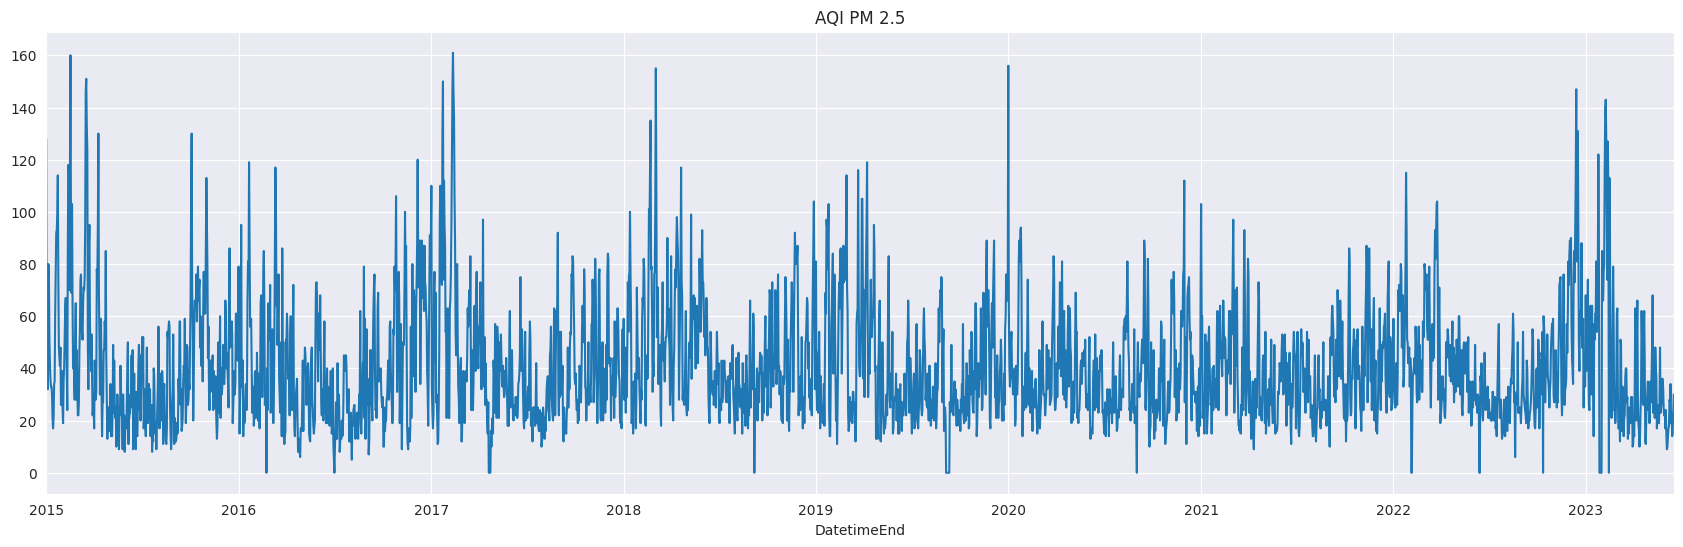

In [4]:
file = "datasets/pollutants-weather-merged-data/aqi_all.csv"
df = pd.read_csv(file, parse_dates=True, index_col=settings.DATE_COLUMN_NAME)
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
df[target_column].plot(ax=ax, title="AQI PM 2.5")

In [3]:
df_train = pd.read_csv(input_train_file, parse_dates=True,
                       index_col=settings.DATE_COLUMN_NAME)
df_train = df_train[[target_column] + exog_columns]
train_ind_end = df_train.index.max()
df_val = pd.read_csv(input_val_file, parse_dates=True,
                     index_col=settings.DATE_COLUMN_NAME)
df_val = df_val[[target_column] + exog_columns]
val_ind_start = df_train.index.max()
y_train = df_train[target_column]
y_val = df_val[target_column]
y = pd.concat([y_train, y_val])

In [44]:
import numpy as np

# prepare Fourier terms
fourier = pd.DataFrame({'DatetimeEnd': y.index})
fourier['DatetimeEnd'] = y.index
fourier = fourier.set_index(fourier['DatetimeEnd'])
fourier.index.freq = 'D'
#exog = exog.set_index(pd.PeriodIndex(exog['DatetimeEnd'], freq='D'))
fourier['sin365'] = np.sin(2 * np.pi * fourier.index.dayofyear / 365.25)
fourier['cos365'] = np.cos(2 * np.pi * fourier.index.dayofyear / 365.25)
# fourier['sin365_2'] = np.sin(4 * np.pi * fourier.index.dayofyear / 365.25)
# fourier['cos365_2'] = np.cos(4 * np.pi * fourier.index.dayofyear / 365.25)
# exog['DatetimeEnd'] = y.index
# exog = exog.set_index(exog['DatetimeEnd'])
# exog.index.freq = 'D'
fourier = fourier.drop(columns=['DatetimeEnd'])
fourier_train = fourier.iloc[:(len(y)-len(y_val))]
fourier_test = fourier.iloc[(len(y)-len(y_val)):]

In [45]:
exog_train = df_train[exog_columns]
exog_val = df_val[exog_columns]
exog_fourier_train = fourier.merge(exog_train, left_index=True,
                                            right_index=True)
exog_fourier_val = fourier.merge(exog_val, left_index=True,
                                        right_index=True)

In [6]:
auto_arima_params = {
    "test" : "adf",
    "seasonal": False,
    "d": 1,
    "m": 7,
    "start_p": 0,
    "start_q": 0,
    "start_P": 0,
    "start_Q": 0,
    "max_p": 7,
    "max_q": 7,
    "trace": True,
    "error_action": "ignore",
    "suppress_warnings": True,
    "stepwise": True
}

In [52]:
#model = pm.auto_arima(y=y_train, exogenous=exog_fourier_train, **auto_arima_params)
model = pm.auto_arima(y=y_train, **auto_arima_params)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25354.293, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25288.418, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25236.000, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25352.293, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24825.594, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24821.196, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25155.841, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24816.237, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25131.221, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24812.235, Time=0.78 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=25077.867, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24814.001, Time=0.86 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=24813.797, Time=1.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24812.039, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0

In [53]:
forecast = model.predict(n_periods=len(y_val))
forecast

2023-05-01    27.133249
2023-05-02    30.364700
2023-05-03    31.380025
2023-05-04    32.574796
2023-05-05    32.894407
2023-05-06    33.339706
2023-05-07    33.435907
Freq: D, dtype: float64

In [54]:
from sklearn.metrics import mean_squared_error
#no exog 8.63215233629041 (2,1,2)
#weather exog 12.092125778108928 (3,1,2)
#weather fourier 11.234836697884322 (0,1,5)
#fourier 9.1863503449367 (0,1,4)
mean_squared_error(y_true=y_val, y_pred=forecast, squared=False)

8.63215233629041

In [61]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2952
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -12399.422
Date:                Sun, 25 Jun 2023   AIC                          24808.844
Time:                        18:40:20   BIC                          24838.793
Sample:                    04-01-2015   HQIC                         24819.626
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0637      0.106     -0.599      0.549      -0.272       0.145
ar.L2          0.3897      0.076      5.146      0.000       0.241       0.538
ma.L1         -0.2465      0.103     -2.405      0.016      -0.447      -0.046
ma.L2         -0.7006      0.101     -6.905      0.000      -0.899      -0.502
sigma2       261.1573      4.992     52.312      0.000     251.373     270.942
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               448.08
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.28
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

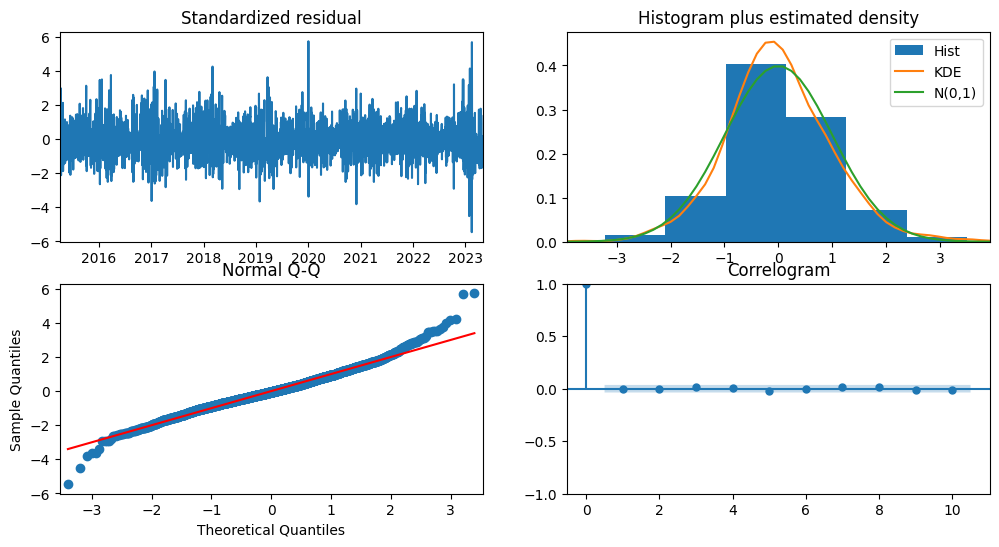

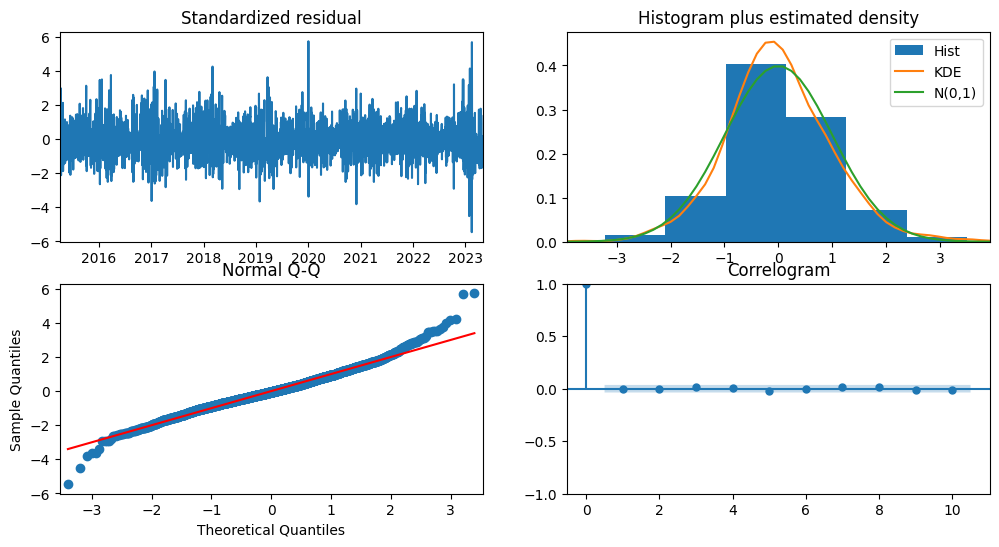

In [55]:
display(model.summary())
model.plot_diagnostics(figsize=(12,6))